## Project - Linear Classification - Predict Survival from a Ship mishap

So far we have developed a fair understanding of feature columns, data pipelines, and TensorFlow estimators

Now let’s focus on building a Classification model using a real dataset, the Titanic data set.

There are 627 sample cases in the training dataset and 264 cases in test dataset

10 attributes have been assigned to each passenger

We will use a Tensor Flow estimator to build a linear regression model

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_x = pd.read_csv('train.csv')

In [6]:
eval_x = pd.read_csv('eval.csv')

In [7]:
train_y = train_x.pop('survived')

In [8]:
eval_y = eval_x.pop('survived')

## Explore Data

## List the features in the dataset

In [10]:
train_x.head().T

,0,1,2,3,4
sex,male,female,female,female,male
age,22.0,38.0,26.0,35.0,28.0
n_siblings_spouses,1,1,0,1,0
parch,0,0,0,0,0
fare,7.25,71.2833,7.925,53.1,8.4583
class,Third,First,Third,First,Third
deck,unknown,C,unknown,C,unknown
embark_town,Southampton,Cherbourg,Southampton,Southampton,Queenstown
alone,n,n,y,n,y


## Statistical Analysis of the data

In [11]:
train_x.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


## Number of records in each dataset

In [12]:
train_x.shape[0], eval_x.shape[0]

(627, 264)

## Age distribution of the passengers

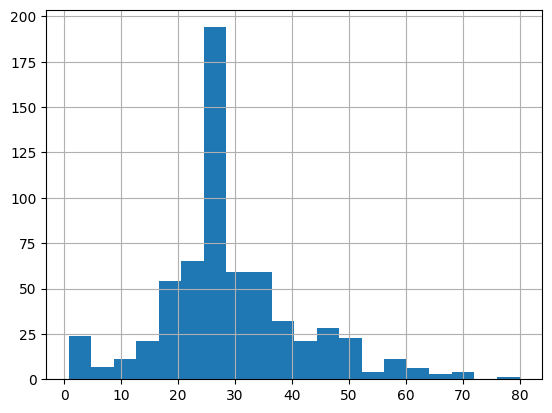

In [14]:
train_x.age.hist(bins=20)
plt.show()

## Gender distribution of the passengers

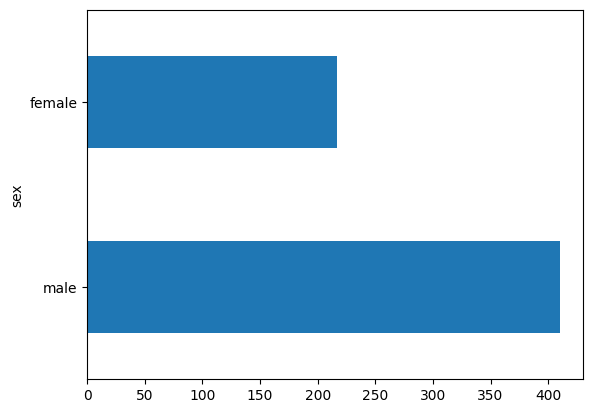

In [17]:
train_x.sex.value_counts().plot(kind='barh')
plt.show()

Males are more than double than females

## Distribution by class

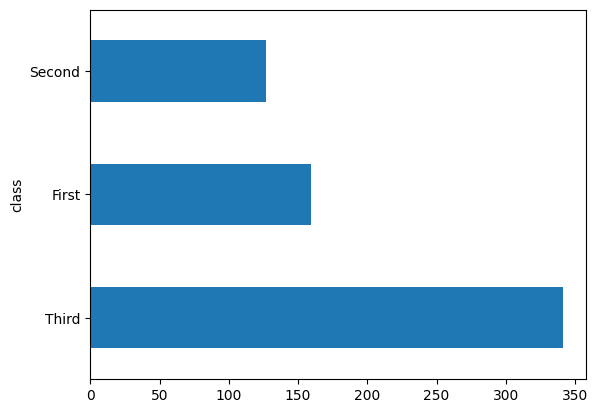

In [19]:
train_x['class'].value_counts().plot(kind='barh')
plt.show()

## Analyze the survival chances by sex

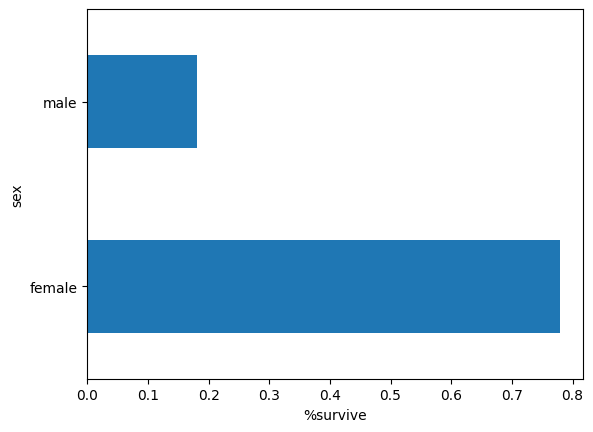

In [21]:
pd.concat([train_x, train_y], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('%survive')
plt.show()

## Feature Column and Input Function

### Feature Column

In [23]:
CAT_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

In [27]:
NUM_COLUMNS = ['age', 'fare']

In [28]:
feature_columns = []

In [31]:
for feature in CAT_COLUMNS:
    vocabulary = train_x[feature].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocabulary))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [32]:
for feature in NUM_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


## Input Function

In [34]:
def input_func(input_data, label_data, num_epochs=10,
               shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(input_data), label_data))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

In [35]:
train_input_fn = input_func(train_x, train_y)

In [36]:
eval_input_fn = input_func(eval_x, eval_y, num_epochs=1, shuffle=False)

The input_function converts the data to a tf.data.Dataset

It feeds the input pipeline

# Inspect Dataset

In [37]:
ds = input_func(train_x, train_y, batch_size=10)()

In [38]:
for feature_batch, label_batch in ds.take(1):
    print('Feature keys :', list(feature_batch.keys()))
    print()
    print('Class Batch :', feature_batch['class'].numpy())
    print()
    print('Labels Batch:', label_batch.numpy())

Feature keys : ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

Class Batch : [b'Third' b'Third' b'Third' b'Third' b'First' b'Third' b'Third' b'Third'
 b'Second' b'Second']

Labels Batch: [1 0 0 1 0 0 1 0 1 0]


# Inspect Specific Feature Column

In [39]:
age_column = feature_columns[7]

In [40]:
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[27.],
       [ 9.],
       [48.],
       [28.],
       [70.],
       [24.],
       [28.],
       [17.],
       [45.],
       [59.]], dtype=float32)

# Inspect Categorical Feature Column

In [41]:
gender_column = feature_columns[0]

In [42]:
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)>>

# Estimator Model and Validation

In [44]:
model = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\mukes\\AppData\\Local\\Temp\\tmpwo6d_6jo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [45]:
model.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\mukes\AppData\Local\Temp\tmpwo6d_6jo\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
Instructions for updating:
Use tf.keras instead.


In [46]:
result = model.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-09-17T09:43:24
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\mukes\AppData\Local\Temp\tmpwo6d_6jo\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.03257s
INFO:tensorflow:Finished evaluation at 2023-09-17-09:43:25
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.7386364, accuracy_baseline = 0.625, auc = 0.83180285, auc_precision_recall = 0.79828036, average_loss = 0.480906, global_step = 200, label/mean = 0.375, loss = 0.47387764, precision = 0.65, prediction/mean = 0.40829763, recall = 0.65656567
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: C:\Users\mukes\AppData\Local\Temp\tmpwo6d_6jo\model.ckpt-200


In [47]:
print(result)

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.83180285, 'auc_precision_recall': 0.79828036, 'average_loss': 0.480906, 'label/mean': 0.375, 'loss': 0.47387764, 'precision': 0.65, 'prediction/mean': 0.40829763, 'recall': 0.65656567, 'global_step': 200}


# Predictions

In [48]:
prediction = list(model.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\mukes\AppData\Local\Temp\tmpwo6d_6jo\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [49]:
probabs = pd.Series([pred['probabilities'][1] for pred in prediction])

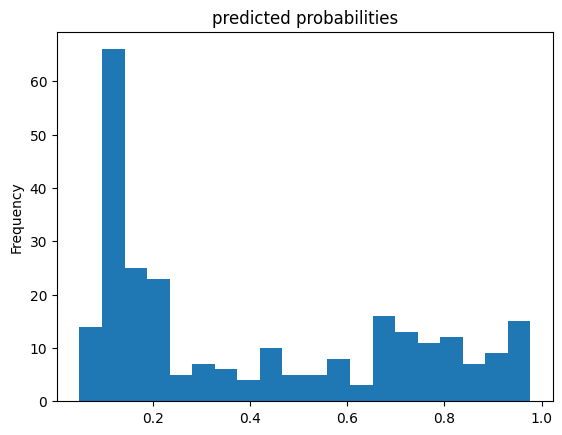

In [50]:
probabs.plot(kind='hist', bins=20, title='predicted probabilities') 
plt.show()

# ROC Curve

In [51]:
from sklearn.metrics import roc_curve

In [52]:
false_pr, true_pr, _ = roc_curve(eval_y, probabs)

[]

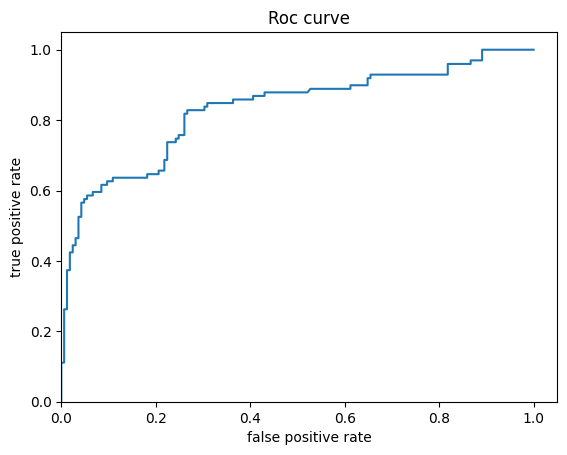

In [54]:
plt.plot(false_pr, true_pr)
plt.title('Roc curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.plot()